## Libraries and Helper Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

from umap.umap_ import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired,MaximalMarginalRelevance
from bertopic.representation import OpenAI as OpenAI_BERTopic
from sentence_transformers import SentenceTransformer

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

import os
from dotenv import load_dotenv

import optuna

nltk.download('punkt')
nltk.download('stopwords')

import torch
import random
import os

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import torch
import torchvision

In [3]:
load_dotenv(override=True)

True

In [4]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.StopWordRemover.StopWordRemover import StopWordRemover

In [5]:
import os
import json
import re
from openai import OpenAI
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI()

def summarize_topic(keywords, docs):
    prompt = f"Saya mempunyai sebuah topik terkait penelitian ilmiah atau pengabdian masyarakat yang dapat di-deskripsikan dengan beberapa kata kunci berikut: {keywords}\n\n"
    prompt += "Di dalam topik ini, dokumen-dokumen berikut adalah judul penelitian atau pengabdian masyarakat yang merupakan sebagian kecil namun representatif dari semua dokumen dalam topik ini:\n\n"
    prompt += "\n\n".join(docs[:5])  # ambil 5 dokumen saja
    prompt += 'Berdasarkan informasi di atas, deskripsikan topik ini dan berikan label berupa satu kalimat yang representatif terhadap topik ini dengan format JSON berikut:\n {"label_topik":<label> , "deskripsi":<deskripsi>}'

    response = client.chat.completions.create(
        model="gpt-4o-2024-08-06",
        messages=[
            {"role": "system", "content": 'Kamu adalah asisten akademik yang merangkum topik. Anda adalah model yang hanya menjawab dalam format JSON valid. Jangan beri penjelasan. Berikan hanya output seperti ini: {"label_topik": "...", "deskripsi": "..."}'},
            {"role": "user", "content": prompt}
        ],
        temperature=0.5,
        max_tokens=300
    )
    content = response.choices[0].message.content.strip()
    try:
        match = re.search(r'\{.*?\}', content, re.DOTALL)
        json_str = match.group(0)
        result = json.loads(json_str)
        return result
    except json.JSONDecodeError:
        print("JSON tidak valid:", content)


In [6]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import time
class StopWatch():
    def __init__(self):
        self.__start_time = 0
        self.__end_time = 0
        self.__elapsed_time = 0
    def start(self):
        self.__start_time = time.time()
        self.__end_time = 0
    def stop(self):
        self.__end_time = time.time()
        self.__elapsed_time = self.__end_time - self.__start_time
    def print(self):
        detik = self.__elapsed_time

        jam = detik // 3600
        detik = detik % 3600

        menit = detik // 60
        detik = detik % 60

        print('Waktu eksekusi: ',end='')
        if jam != 0:
            print(int(jam),'jam ',end='')
        if menit != 0:
            print(int(menit),'menit',end='')
        print(f' {detik:.2f}','detik.')
    def get_elapsed_time(self):
        return self.__elapsed_time

In [8]:
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()  
repeated_phrases = ["kecerdasan buatan"]

additional_stop_words = ['ai']

stop_words = set(stopwords.words('english'))
for word in additional_stop_words:
    stop_words.add(word)

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # URL removal
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Punctuation removal
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove repeated phrases
    for phrase in repeated_phrases:
        text = re.sub(phrase,"",text)

    # Remove duplicate white space
    text = re.sub(r'\s+', ' ', text)
    
    text = stopword_remover.remove(text) 

     # Tokenization
    tokens = word_tokenize(text)
    
    # Stopword removal
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

In [9]:
def trim(x):
    if x[-8:]=='Collapse':
        return x[:-8]
    elif x[-9:] == ' … Expand':
        return x[:-9]
    else:
        return x

In [10]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [11]:
def get_topics_words(model, vectorizer):
    feature_names = vectorizer.get_feature_names_out()
    topics_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-11:-1]
        top_words = [feature_names[i] for i in top_features_ind]
        topics_words.append(top_words)

    return topics_words

def get_bert_topics_words(topic_model):
    bert_topics_words = []
    for topic_id in topic_model.get_topics().keys():
        if topic_id == -1:
            continue
        topic_words = [word for word, _ in topic_model.get_topic(topic_id)]
        bert_topics_words.append(topic_words)
    return bert_topics_words

def get_coherence(topics_words):
    sw = StopWatch()
    sw.start()
    
    coherence = CoherenceModel(
                    topics=topics_words,
                    texts=tokenized_docs,
                    dictionary=dictionary,
                    coherence='c_v'
                ).get_coherence()

    sw.stop()
    sw.print()

    return coherence

In [12]:
config = {
    'dataset_dir' : '../../Datasets/'
}

## EDA

In [13]:
df_penelitian = pd.read_csv(config['dataset_dir']+'Daftar Penerima Pendanaan Program Penelitian Tahun Anggaran 2024.csv')
df_abdimas = pd.read_csv(config['dataset_dir']+'Penerima Pendanaan Program Pengabdian kepada Masyarakat Batch II  Tahun  Anggaran 2025.csv')

In [14]:
df_penelitian

,No,Kategori Institusi,Nama Institusi,NIDN,Nama,Judul,Ruang Lingkup
0,1,PTNBH,Institut Pertanian Bogor,27046503,Achmad Farajallah,Pola Distribusi Macrobrachium Sintangense di J...,PPS- PTM
1,2,PTNBH,Institut Pertanian Bogor,24129002,Adisti Permatasari Putri Hartoyo,APLIKASI BIO-NANOFERTILIZERS DAN DRONE SEEDING...,PFR
2,3,PTNBH,Institut Pertanian Bogor,24129002,Adisti Permatasari Putri Hartoyo,APLIKASI SEED BOMB TECHNOLOGY DAN NANO- CS/PMA...,PPS- PTM
3,4,PTNBH,Institut Pertanian Bogor,2076607,Agus Buono,Optimasi Model Hybrid Convolutional Vision Tra...,PPS- PDD
4,5,PTNBH,Institut Pertanian Bogor,18096208,Agus Hikmat,Pengembangan Sistem Agroforestri dan Produk Ar...,PFR
...,...,...,...,...,...,...,...
11989,11990,LLDIKTI Wilayah XVI,Universitas Trinita,912086503,Yongker Baali,Pemanfaatan Limbah Tempurung Kelapa untuk pros...,PDP Reguler
11990,11991,LLDIKTI Wilayah XVI,Universitas Widya Nusantara,1613039801,Hardianti,Nuget Daun Krokot Dan Tepung Bekatul Sebagai A...,PDP Reguler
11991,11992,LLDIKTI Wilayah XVI,Universitas Widya Nusantara,917068903,Matius Paundanan,"Studi Kandungan Logam Berat (Hg, Pb, Cd dan Cu...",PDP Reguler
11992,11993,LLDIKTI Wilayah XVI,Universitas Widya Nusantara,1602099801,Nuristha Febrianti,Pemanfaatan Pangan Lokal Stik Dangke Kelor Seb...,PDP Reguler


In [15]:
df_abdimas = df_abdimas.rename(columns={'Institusi':'Nama Institusi'})

In [16]:
df = pd.concat([df_penelitian[['Nama Institusi','Judul']],df_abdimas[['Nama Institusi','Judul']]]).reset_index(drop=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12490 entries, 0 to 12489
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Nama Institusi  12490 non-null  object
 1   Judul           12490 non-null  object
dtypes: object(2)
memory usage: 195.3+ KB


## Preprocessing and Feature Engineering #1

In [18]:
df_tm = df[['Judul']].copy()

In [19]:
sw = StopWatch()
sw.start()
df_tm['processed_judul'] = df_tm['Judul'].apply(preprocess_text)
sw.stop()
sw.print()

Waktu eksekusi:  1.98 detik.


In [20]:
df_tm.head()

,Judul,processed_judul
0,Pola Distribusi Macrobrachium Sintangense di J...,pola distribusi macrobrachium sintangense jawa...
1,APLIKASI BIO-NANOFERTILIZERS DAN DRONE SEEDING...,aplikasi bionanofertilizers drone seeding sist...
2,APLIKASI SEED BOMB TECHNOLOGY DAN NANO- CS/PMA...,aplikasi seed bomb technology nano cspmaanpkmi...
3,Optimasi Model Hybrid Convolutional Vision Tra...,optimasi model hybrid convolutional vision tra...
4,Pengembangan Sistem Agroforestri dan Produk Ar...,pengembangan sistem agroforestri produk berbas...


## Topic Modelling

In [21]:
docs = df_tm['processed_judul'].to_list()

In [22]:
def get_top_keyword(vectorizer,model):
    componenets = model.components_
    feature_names = vectorizer.get_feature_names_out()
    top_n = 10
    keywords_per_topic = [
        [feature_names[i] for i in topic.argsort()[:-top_n - 1:-1]] for topic in componenets
    ]
    return keywords_per_topic

def select_representative_docs(model,topics):
    topics_docs = {}
    for topic_idx in range(model.n_components):
        topic_strength = topics[:,topic_idx]
        top_doc_indices = topic_strength.argsort()[::-1][:5]
        topics_docs[topic_idx] = [docs[i] for i in top_doc_indices]
    return topics_docs

In [23]:
def summarize(model, topics, vectorizer):
    r_docs = select_representative_docs(model,topics)
    top_key = get_top_keyword(vectorizer,model)
    topic_desc = {}
    for topic_idx, keywords in enumerate(top_key):
        docs_sample = r_docs[topic_idx]
        result = summarize_topic(keywords, docs_sample)
        topic_desc[topic_idx] = result
    return topic_desc

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(df_tm['processed_judul'])

count_vectorizer = CountVectorizer(max_features=1000)
count = count_vectorizer.fit_transform(df_tm['processed_judul'])

### NMF

In [25]:
sw = StopWatch()
sw.start()
nmf_model = NMF(n_components=10, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf)
sw.stop()
sw.print()

Waktu eksekusi:  0.83 detik.


In [26]:
df_tm['NMF_topic'] = np.argmax(nmf_topics,axis=1)

In [27]:
df_tm['NMF_topic'].value_counts()

NMF_topic
4    1559
8    1558
6    1543
7    1495
3    1365
5    1361
2    1056
0     966
1     901
9     686
Name: count, dtype: int64

### LDA

In [28]:
sw = StopWatch()
sw.start()
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda_model.fit_transform(count)
sw.stop()
sw.print()

Waktu eksekusi:  24.57 detik.


In [29]:
df_tm['LDA_topic'] = np.argmax(lda_topics,axis=1)

In [30]:
df_tm['LDA_topic'].value_counts()

LDA_topic
5    2031
1    1864
4    1734
3    1319
8    1082
9    1042
0     939
7     899
6     795
2     785
Name: count, dtype: int64

### LSA

In [31]:
sw = StopWatch()
sw.start()
lsa_model = TruncatedSVD(n_components=10, random_state=42)
lsa_topics = lsa_model.fit_transform(tfidf)
sw.stop()
sw.print()

Waktu eksekusi:  0.06 detik.


In [32]:
df_tm['LSA_topics'] = np.argmax(lsa_topics,axis=1)

In [33]:
df_tm['LSA_topics'].value_counts()

LSA_topics
0    7477
2    1526
5     927
6     808
7     592
9     414
4     210
8     201
1     188
3     147
Name: count, dtype: int64

### BERTopic

In [34]:
# Prepare sub-models
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
hdbscan_model = HDBSCAN(min_samples=20, gen_min_span_tree=True, prediction_data=True, min_cluster_size=20)
vectorizer_model = CountVectorizer(ngram_range=(1, 3), min_df=5)

In [35]:
# Representation models
representation_models = {
    "KeyBERTInspired": KeyBERTInspired()
}

# Fit BERTopic
sw = StopWatch()
sw.start()

topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_models,
        verbose=True
).fit(docs)

sw.stop()
sw.print()

2025-07-28 07:08:39,683 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

2025-07-28 07:08:50,582 - BERTopic - Embedding - Completed ✓
2025-07-28 07:08:50,583 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Mon Jul 28 07:08:50 2025 Construct fuzzy simplicial set
Mon Jul 28 07:08:50 2025 Finding Nearest Neighbors
Mon Jul 28 07:08:50 2025 Building RP forest with 11 trees
Mon Jul 28 07:09:03 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Jul 28 07:09:41 2025 Finished Nearest Neighbor Search
Mon Jul 28 07:09:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jul 28 07:10:01 2025 Finished embedding


2025-07-28 07:10:01,201 - BERTopic - Dimensionality - Completed ✓
2025-07-28 07:10:01,203 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-28 07:10:01,956 - BERTopic - Cluster - Completed ✓
2025-07-28 07:10:01,964 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-28 07:10:05,440 - BERTopic - Representation - Completed ✓


Waktu eksekusi: 1 menit 26.21 detik.


In [36]:
topic_info = topic_model.get_topic_info()  
id_to_name = topic_info.set_index("Topic")["Name"].to_dict()

In [37]:
id_to_name

{-1: '-1_berbasis_pengembangan_model_indonesia',
 0: '0_menggunakan_deep_deteksi_sistem',
 1: '1_wisata_tourism_desa wisata_destinasi',
 2: '2_bakteri_tanaman_endofit_senyawa',
 3: '3_ikan_perikanan_perairan_pakan',
 4: '4_budaya_adat_masyarakat_tradisi',
 5: '5_marketing_digital marketing_digital_pemasaran',
 6: '6_pangan_ketahanan pangan_ketahanan_petani',
 7: '7_listrik_energi_pembangkit_surya',
 8: '8_reality_augmented_augmented reality_virtual',
 9: '9_matematika_kemampuan_siswa_pembelajaran',
 10: '10_inggris_bahasa inggris_bahasa_membaca',
 11: '11_kanker_payudara_sel_antikanker',
 12: '12_bencana_mitigasi_banjir_tsunami',
 13: '13_green_hijau_green economy_economy',
 14: '14_antioksidan_ekstrak_daun_etanol',
 15: '15_ion_sensor_material_oksida',
 16: '16_berpikir_keterampilan_berpikir kritis_kritis',
 17: '17_sapi_daging_ayam_telur',
 18: '18_diabetes_tikus_ekstrak_daun',
 19: '19_nanopartikel_luka_ekstrak_delivery',
 20: '20_ibu_bayi_stunting_pencegahan',
 21: '21_katalis_baha

In [38]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERTInspired,Representative_Docs
0,-1,6692,-1_berbasis_pengembangan_model_indonesia,"[berbasis, pengembangan, model, indonesia, men...","[pembelajaran, learning, pendidikan, sekolah d...",[konstruktivisme model pembelajaran cognitive ...
1,0,586,0_menggunakan_deep_deteksi_sistem,"[menggunakan, deep, deteksi, sistem, learning,...","[machine learning, neural network, artificial ...",[pengklasifikasi bibit kelapa menggunakan algo...
2,1,455,1_wisata_tourism_desa wisata_destinasi,"[wisata, tourism, desa wisata, destinasi, desa...","[tourism, desa wisata, wisatawan, wisata, kota...",[optimalisasi desa wisata berbasis umkm melalu...
3,2,362,2_bakteri_tanaman_endofit_senyawa,"[bakteri, tanaman, endofit, senyawa, daun, baw...","[bakteri, senyawa bioaktif, infeksi, bioaktif,...",[analisis senyawa bioaktif identifikasi moleku...
4,3,208,3_ikan_perikanan_perairan_pakan,"[ikan, perikanan, perairan, pakan, dna, endemi...","[perikanan, ikan, ekosistem, wilayah pesisir, ...",[rekonstruksi modernisasi perikanan tangkap tr...
5,4,180,4_budaya_adat_masyarakat_tradisi,"[budaya, adat, masyarakat, tradisi, suku, iden...","[masyarakat adat, masyarakat suku, budaya loka...",[elaborasi studi antropologi hukum antropoling...
6,5,173,5_marketing_digital marketing_digital_pemasaran,"[marketing, digital marketing, digital, pemasa...","[digital marketing, pemasaran digital, marketi...",[kpopfikasi digital marketing akselerasi visib...
7,6,169,6_pangan_ketahanan pangan_ketahanan_petani,"[pangan, ketahanan pangan, ketahanan, petani, ...","[ketahanan pangan, mitigasi perubahan iklim, p...",[transformasi lumbung pangan desa berketahanan...
8,7,169,7_listrik_energi_pembangkit_surya,"[listrik, energi, pembangkit, surya, tenaga, p...","[pembangkit listrik tenaga, energi terbarukan,...",[optimalisasi energi angin pembangkit listrik ...
9,8,162,8_reality_augmented_augmented reality_virtual,"[reality, augmented, augmented reality, virtua...","[berbasis augmented reality, augmented reality...",[optimalisasi pembelajaran vokasional berbasis...


In [39]:
sw = StopWatch()
sw.start()

bert_topics, probs = topic_model.transform(docs)

sw.stop()
sw.print()

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

2025-07-28 07:10:16,367 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-28 07:10:16,404 - BERTopic - Dimensionality - Completed ✓
2025-07-28 07:10:16,405 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-28 07:10:17,105 - BERTopic - Cluster - Completed ✓


Waktu eksekusi:  11.08 detik.


In [40]:
df_tm['BERT_topic'] = bert_topics

### Evaluating #1

In [25]:
# Tokenisasi dokumen
tokenized_docs = [doc.split() for doc in docs]

dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [42]:
nmf_topics_words = get_topics_words(nmf_model,tfidf_vectorizer)
lda_topics_words = get_topics_words(lda_model,count_vectorizer)
lsa_topics_words = get_topics_words(lsa_model,tfidf_vectorizer)

In [43]:
bert_topics_words = get_bert_topics_words(topic_model)

In [44]:
sw.start()

coherence_dict = {
    'Model' : [
        'NMF',
        'LDA',
        'LSA',
        'BERTopic',
    ],
    'Coherence':[
        get_coherence(nmf_topics_words),
        get_coherence(lda_topics_words),
        get_coherence(lsa_topics_words),
        get_coherence(bert_topics_words),
    ]
}

sw.stop()
sw.print()

Waktu eksekusi:  11.16 detik.
Waktu eksekusi:  11.04 detik.
Waktu eksekusi:  10.84 detik.
Waktu eksekusi:  11.67 detik.
Waktu eksekusi:  44.71 detik.


In [45]:
coherence_df = pd.DataFrame(coherence_dict)

In [46]:
coherence_df

,Model,Coherence
0,NMF,0.651512
1,LDA,0.508846
2,LSA,0.459366
3,BERTopic,0.626531


### Hyperparameter Tuning

In [47]:
optuna.__version__

'4.4.0'

In [48]:
def nmf_objective(trial):
    params = {
        'n_components': trial.suggest_int('n_components', 3, 100)
    }

    model = NMF(**params, random_state=42)
    topics = model.fit_transform(tfidf)

    topics_words = get_topics_words(model, tfidf_vectorizer)
    return get_coherence(topics_words)

def lda_objective(trial):
    params = {
        'n_components': trial.suggest_int('n_components', 3, 30)
    }

    model = LatentDirichletAllocation(**params, random_state=42)
    topics = model.fit_transform(count)

    topics_words = get_topics_words(model, count_vectorizer)
    return get_coherence(topics_words)

def lsa_objective(trial):
    params = {
        'n_components': trial.suggest_int('n_components', 3, 30)
    }

    model = TruncatedSVD(**params, random_state=42)
    topics = model.fit_transform(tfidf)

    topics_words = get_topics_words(model, tfidf_vectorizer)
    return get_coherence(topics_words)

def bert_objective(trial):
    embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
    umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
    hdbscan_model = HDBSCAN(min_samples=20, gen_min_span_tree=True, prediction_data=True, min_cluster_size=trial.suggest_int('min_cluster_size', 3, 30))
    vectorizer_model = CountVectorizer(ngram_range=(1, 3), min_df=5)

    representation_models = {
        "KeyBERTInspired": KeyBERTInspired()
    }

    topic_model= BERTopic(
            embedding_model=embedding_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            representation_model=representation_models,
            verbose=True
    ).fit(docs)

    bert_topics_words = get_bert_topics_words(topic_model)
    return get_coherence(bert_topics_words)

In [49]:
# sw.start()

# nmf_study = optuna.create_study(direction='maximize')
# nmf_study.optimize(nmf_objective,n_trials=50)

# sw.stop()
# sw.print()

In [50]:
nmf_parmas = {'n_components': 10}

In [51]:
# sw.start()

# lda_study = optuna.create_study(direction='maximize')
# lda_study.optimize(lda_objective,n_trials=20)

# sw.stop()
# sw.print()

In [52]:
lda_params = {'n_components': 13}

In [53]:
# sw.start()

# lsa_study = optuna.create_study(direction='maximize')
# lsa_study.optimize(lsa_objective,n_trials=20)

# sw.stop()
# sw.print()

In [54]:
lsa_params = {'n_components': 4}

In [55]:
# sw.start()

# bert_study = optuna.create_study(direction='maximize')
# bert_study.optimize(bert_objective,n_trials=5)

# sw.stop()
# sw.print()

In [56]:
# bert_params = {'min_cluster_size': 22}

In [57]:
nmf_model = NMF(**nmf_parmas, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf)

lda_model = LatentDirichletAllocation(**lda_params, random_state=42)
lda_topics = lda_model.fit_transform(count)

lsa_model = TruncatedSVD(**lsa_params, random_state=42)
lsa_topics = lsa_model.fit_transform(tfidf)

In [26]:
# Prepare sub-models
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
hdbscan_model = HDBSCAN(min_samples=20, gen_min_span_tree=True, prediction_data=True, min_cluster_size=20)
vectorizer_model = CountVectorizer(ngram_range=(1, 3), min_df=5)

# Representation models
representation_models = {
    "KeyBERTInspired": KeyBERTInspired(),
    "MMR": MaximalMarginalRelevance(diversity=0.3),
    "KeyBERT + MMR": [KeyBERTInspired(), MaximalMarginalRelevance(diversity=0.3)]
}

# Fit BERTopic
sw = StopWatch()
sw.start()

topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_models,
        verbose=True
).fit(docs)

sw.stop()
sw.print()


KeyboardInterrupt



In [66]:
nmf_topics_words = get_topics_words(nmf_model,tfidf_vectorizer)
lda_topics_words = get_topics_words(lda_model,count_vectorizer)
lsa_topics_words = get_topics_words(lsa_model,tfidf_vectorizer)

In [67]:
bert_topics_words = get_bert_topics_words(topic_model)

In [68]:
get_coherence(bert_topics_words)

Waktu eksekusi:  11.65 detik.


0.6265311567790711

In [69]:
sw.start()

coherence_dict = {
    'Model' : [
        'NMF',
        'LDA',
        'LSA',
        'BERTopic',
    ],
    'Coherence':[
        get_coherence(nmf_topics_words),
        get_coherence(lda_topics_words),
        get_coherence(lsa_topics_words),
        get_coherence(bert_topics_words),
    ]
}

sw.stop()
sw.print()

Waktu eksekusi:  16.42 detik.
Waktu eksekusi:  10.54 detik.
Waktu eksekusi:  10.32 detik.
Waktu eksekusi:  11.15 detik.
Waktu eksekusi:  48.43 detik.


In [166]:
coherence_df = pd.DataFrame(coherence_dict)
coherence_df.sort_values(by='Coherence',ascending=False)

NameError: name 'coherence_dict' is not defined

## Conclusion

In [80]:
# topic_model.save("BERTopic_Penelitian")

In [27]:
topic_model = BERTopic.load("BERTopic_Penelitian")

Mon Jul 28 21:09:40 2025 Building and compiling search function


In [28]:
def get_top_topics(topics):
    topic_labels = np.argmax(topics,axis=1)
    values,counts = np.unique(topic_labels,return_counts=True)

    sorted_indices = np.argsort(-counts)

    sorted_values = values[sorted_indices]
    sorted_counts = counts[sorted_indices]

    return sorted_values,sorted_counts

In [29]:
def get_sorted_top_keyword(vectorizer,model,sorted_topics):
    componenets = model.components_[sorted_topics]
    feature_names = vectorizer.get_feature_names_out()
    top_n = 10
    keywords_per_topic = [
        [feature_names[i] for i in topic.argsort()[:-top_n - 1:-1]] for topic in componenets
    ]
    return keywords_per_topic

In [30]:
topic_info = topic_model.get_topic_info()

In [34]:
topics,prob = topic_model.transform(docs)

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

In [35]:
df['BERTopic'] = topics
df = df[df['BERTopic'] != -1]

In [36]:
def summarize_bert(topics_info):
    r_docs = topics_info['Representative_Docs'].to_list()
    top_key = topics_info['KeyBERTInspired'].to_list()
    topic_desc = {}
    for topic_idx, keywords in enumerate(top_key):
        docs_sample = r_docs[topic_idx]
        result = summarize_topic(keywords, docs_sample)
        topic_desc[topic_idx] = result
    return topic_desc

In [37]:
topic_info = topic_info.iloc[1:]

In [41]:
topic_info['Representative_Docs'].iloc[0]

['pengklasifikasi bibit kelapa menggunakan algoritma deep learning convolutional neural network',
 'sensor array iot monitoring deteksi dini penyakit lada katokkon toraja berbasis machine learning',
 'pemodelan sistem otentikasi berbasis suara menggunakan mel frequency cepstral coefficients mfcc machine learning']

In [45]:
df.loc[df['BERTopic']==0,'Judul'].to_list()

['Pengembangan Metode Generalized\n  Mixed Effect Support Vector Machine (GMESVM) untuk pemodelan fase pertumbuhan padi berbasis data citra sentinel- 1',
 'Pengembangan Teknologi Fertigator Otomatis Nirdaya untuk Sistem Minapadi Portabel',
 'Pengembangan Metode Generalized\n  Principal Component Analysis untuk Menganalisis Data Indikator\n  Capaian Pembangunan Manusia yang Mengandung\n  Missing Values dan Outliers',
 'Pengembangan Instrumen Portabel untuk Evaluasi Cepat Kualitas Gula Kristal Putih Berbasis Multi-Channel Spectral Sensor dan\n  Embedded Machine Learning',
 'Imputasi Data Curah Hujan Berbasis Machine Learning Menggunakan Pemetaan Data Satelit',
 'Pengembangan Model Smart Count Stomata berbasis\n  Coordinate Attention pada YOLOv5 untuk Penciri Karakter Ideal Varietas Unggul Nilam',
 'Kajian Deteksi Anomali Indeks Kualitas Udara dengan Pendekatan Long Short-Term Memory dan Extreme Gradient Boosting',
 'Kajian Metode Autoencoder dan\n  Long Short-Term Memory Autoencoder dala

In [34]:
bert_sum = summarize_bert(topic_info)

In [155]:
# with open("bert_sum_penelitian.json", "w", encoding="utf-8") as f:
#     json.dump(bert_sum, f, ensure_ascii=False, indent=4)

In [154]:
with open("bert_sum_penelitian.json", "r", encoding="utf-8") as f:
    bert_sum = json.load(f)

In [36]:
(df['BERTopic']==0).sum()

586

In [40]:
with open("insitusi.json", "r", encoding="utf-8") as f:
    institusi_dict = json.load(f)

In [44]:
df['Nama Institusi'] = df['Nama Institusi'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

In [46]:
def get_kota(x):
    result = institusi_dict.get(x,'unknown')
    if result == 'unknown':
        return result
    else:
        return result['kota']
def get_provinsi(x):
    result = institusi_dict.get(x,'unknown')
    if result == 'unknown':
        return result
    else:
        return result['provinsi']

In [47]:
df['Kabupaten/Kota'] = df['Nama Institusi'].apply(get_kota)
df['Provinsi'] = df['Nama Institusi'].apply(get_provinsi)

In [49]:
provinsi_map = {
    "DI Yogyakarta" : "Daerah Istimewa Yogyakarta"
}

In [51]:
df['Provinsi'] = df['Provinsi'].replace(provinsi_map)

In [55]:
df['Kabupaten/Kota'] = df['Kabupaten/Kota'].apply(lambda x: x.replace("Kota ",""))
df['Kabupaten/Kota'] = df['Kabupaten/Kota'].apply(lambda x: x.replace("Kabupaten ",""))

In [62]:
ai_related = df['BERTopic'] == 0

In [148]:
bert_df = pd.DataFrame()
bert_df['topic_id'] = topic_info['Topic']
bert_df['keyword'] = topic_info['KeyBERTInspired']
bert_df['topic_label'] = bert_df['topic_id'].apply(lambda x : bert_sum[x]['label_topik'])
bert_df['topic_desc'] = bert_df['topic_id'].apply(lambda x : bert_sum[x]['deskripsi'])

In [150]:
bert_df.to_csv('Topik Penelitian dan Abdimas.csv',index=False)

In [156]:
df['topic_label'] = df['BERTopic'].apply(lambda x: bert_sum[str(x)]['label_topik'])

In [164]:
def plot_topik_by_tahun(df):
    """
    Membuat barplot distribusi label_topik untuk tahun tertentu.

    Parameter:
    - df: DataFrame yang berisi kolom 'label_topik' dan 'pubdate'
    - tahun: Tahun (integer) yang ingin divisualisasikan
    """
    # Filter berdasarkan tahun
    df_filtered = df.copy()

    if df_filtered.empty:
        print(f"Tidak ada data untuk tahun {tahun}")
        return

    # Hitung frekuensi topik
    topic_counts = df_filtered['topic_label'].value_counts()

    # Plot barplot
    plt.figure(figsize=(12, 10))
    sns.barplot(
        x=topic_counts.values,
        y=topic_counts.index,
        palette="viridis"
    )
    plt.xlabel("Jumlah")
    plt.ylabel("Topik")
    plt.title(f"Distribusi Topik Penelitian dan Abdimas")

    # Ambil 5 topik teratas untuk legend
    top_5_labels = topic_counts.head(5).index.tolist()

    # # Tambahkan legend manual
    # from matplotlib.patches import Patch
    # legend_handles = [Patch(color=sns.color_palette("viridis")[i], label=label)
    #                   for i, label in enumerate(top_5_labels)]
    # plt.legend(handles=legend_handles, title="5 Topik Teratas", loc="upper right")

    plt.tick_params(axis='y', labelsize=9)  # Atur ukuran label y-axis
    plt.tight_layout()
    plt.savefig(f"Distribusi Topik Penelitian dan Abdimas.png",dpi=300, bbox_inches="tight")
    plt.show()

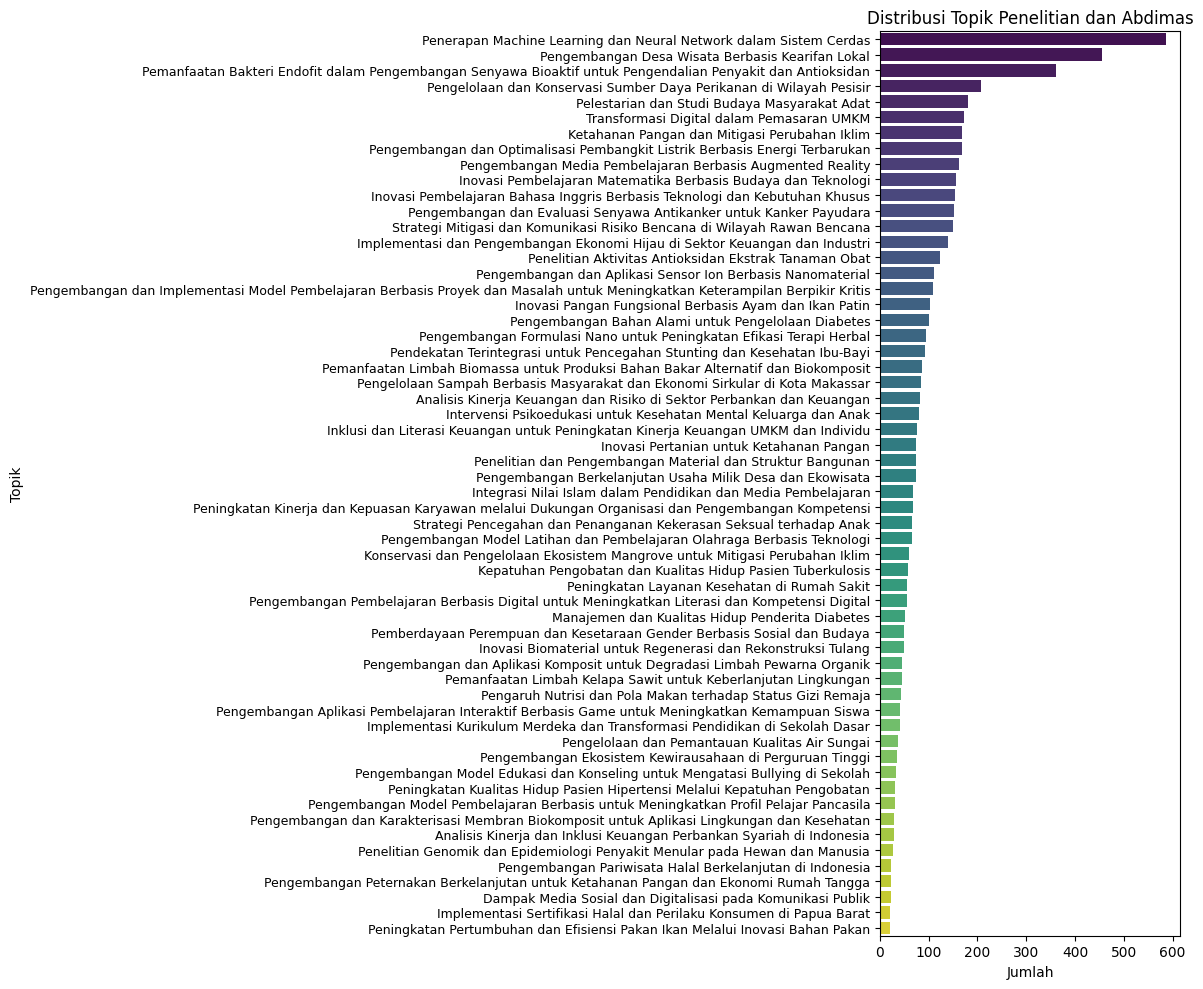

In [165]:
plot_topik_by_tahun(df)

#### Distribusi

In [67]:
from geopy.geocoders import Nominatim

In [87]:
import folium

In [68]:
geolocator = Nominatim(user_agent="kota_visualisasi")

In [ ]:
daftar_kota = list(df['Provinsi'].unique())

In [70]:
from geopy.geocoders import Nominatim

# Inisialisasi geolocator
geolocator = Nominatim(user_agent="provinsi_visualisasi")

# Daftar provinsi
daftar_provinsi = list(df['Provinsi'].unique())

# Geocoding tiap provinsi
provinsi_data = []
for prov in daftar_provinsi:
    try:
        location = geolocator.geocode(prov + ", Indonesia")
        if location:
            provinsi_data.append({'provinsi': prov, 'lat': location.latitude, 'lon': location.longitude})
        else:
            provinsi_data.append({'provinsi': prov, 'lat': None, 'lon': None})
    except:
        provinsi_data.append({'provinsi': prov, 'lat': None, 'lon': None})
    time.sleep(1)  # Rate limit Nominatim

In [78]:
df_prov = pd.DataFrame(df[ai_related]['Provinsi'].value_counts()).reset_index()

In [80]:
def get_lat(x):
    for data in provinsi_data:
        if data['provinsi'] == x:
            return data['lat']
    return np.nan

In [82]:
def get_lon(x):
    for data in provinsi_data:
        if data['provinsi'] == x:
            return data['lon']
    return np.nan

In [83]:
df_prov['lat'] = df_prov['Provinsi'].apply(get_lat)
df_prov['lon'] = df_prov['Provinsi'].apply(get_lon)

In [89]:
# Peta
m = folium.Map(location=[-2, 118], zoom_start=5)

# Tambahkan lingkaran berdasarkan value_counts
for _, row in df_prov.iterrows():
    if pd.notnull(row['lat']) and pd.notnull(row['lon']):
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=row['count'] / 10,  # skala radius
            popup=f"{row['Provinsi']}: {row['count']}",
            color='blue',
            fill=True,
            fill_opacity=0.6
        ).add_to(m)

m.save("peta_value_counts.html")

In [91]:
df_prov = pd.DataFrame(df[ai_related]['Provinsi'].value_counts()).reset_index()

In [96]:
# URL mentah (raw) GeoJSON
geojson_url = "https://raw.githubusercontent.com/superpikar/indonesia-geojson/9469aec5e4112873fc4f457d41b50bec7a591f5d/indonesia.geojson"

response = requests.get(geojson_url)
geojson_data = response.json()  # Harusnya berhasil sekarang

In [104]:
geojson_data

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[97.976814, 4.627501],
       [98.001732, 4.609802],
       [98.002502, 4.626111],
       [98.018059, 4.602221],
       [97.984673, 4.56777],
       [97.976112, 4.577502],
       [97.964165, 4.566667],
       [97.981369, 4.573796],
       [97.979691, 4.544725],
       [97.955276, 4.55028],
       [97.972733, 4.5398],
       [97.950836, 4.531944],
       [97.970619, 4.522869],
       [97.976295, 4.558143],
       [97.99472, 4.509722],
       [98.040001, 4.546391],
       [98.015274, 4.516389],
       [98.033058, 4.502778],
       [98.006668, 4.484167],
       [98.036942, 4.476388],
       [98.01889, 4.486671],
       [98.034721, 4.504444],
       [98.01722, 4.516389],
       [98.048332, 4.50639],
       [98.065407, 4.553231],
       [98.085564, 4.532343],
       [98.062714, 4.52582],
       [98.079262, 4.515678],
       [98.052574, 4.509319],
       [98.069611, 4

In [110]:
print(geojson_data['features'][0]['properties'].keys())

dict_keys(['cartodb_id', 'country', 'id_1', 'slug', 'state'])


In [111]:
import folium
import requests

geojson_url = "https://raw.githubusercontent.com/superpikar/indonesia-geojson/9469aec5e4112873fc4f457d41b50bec7a591f5d/indonesia.geojson"

response = requests.get(geojson_url)
geojson_data = response.json()  # Harusnya berhasil sekarang

# Normalisasi nama provinsi (wajib cocok!)
df_prov['Provinsi'] = df_prov['Provinsi'].str.title()  # Sesuaikan huruf kapital

# Buat peta
m = folium.Map(location=[-2, 118], zoom_start=5)

# Tambahkan choropleth
folium.Choropleth(
    geo_data=geojson_data,
    name='choropleth',
    data=df_prov,
    columns=['Provinsi', 'count'],
    key_on='feature.properties.state',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Jumlah Data per Provinsi'
).add_to(m)

folium.LayerControl().add_to(m)
m.save('choropleth_provinsi.html')


In [129]:
gdf = gpd.read_file("https://raw.githubusercontent.com/superpikar/indonesia-geojson/master/indonesia.geojson")

In [118]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load GeoJSON provinsi Indonesia
gdf = gpd.read_file("https://raw.githubusercontent.com/superpikar/indonesia-geojson/master/indonesia.geojson")
gdf = gdf.rename(columns={'state':'Provinsi'})


# Gabungkan data dengan GeoDataFrame
gdf = gdf.merge(df_prov, on='Provinsi', how='left')

In [124]:
df_prov['Provinsi']

0                     Jawa Timur
1                     Jawa Barat
2                    Jawa Tengah
3     Daerah Istimewa Yogyakarta
4                    Dki Jakarta
5               Sumatera Selatan
6                           Bali
7               Sulawesi Selatan
8                 Sumatera Barat
9                        Lampung
10                Sumatera Utara
11                       Unknown
12                          Riau
13                          Aceh
14                        Banten
15              Kalimantan Timur
16             Sulawesi Tenggara
17           Nusa Tenggara Barat
18                 Papua Selatan
19     Kepulauan Bangka Belitung
20                     Gorontalo
21              Kalimantan Utara
22                Sulawesi Utara
23                Kepulauan Riau
24                         Jambi
25              Kalimantan Barat
26                        Maluku
27               Sulawesi Tengah
28            Kalimantan Selatan
29           Nusa Tenggara Timur
30        

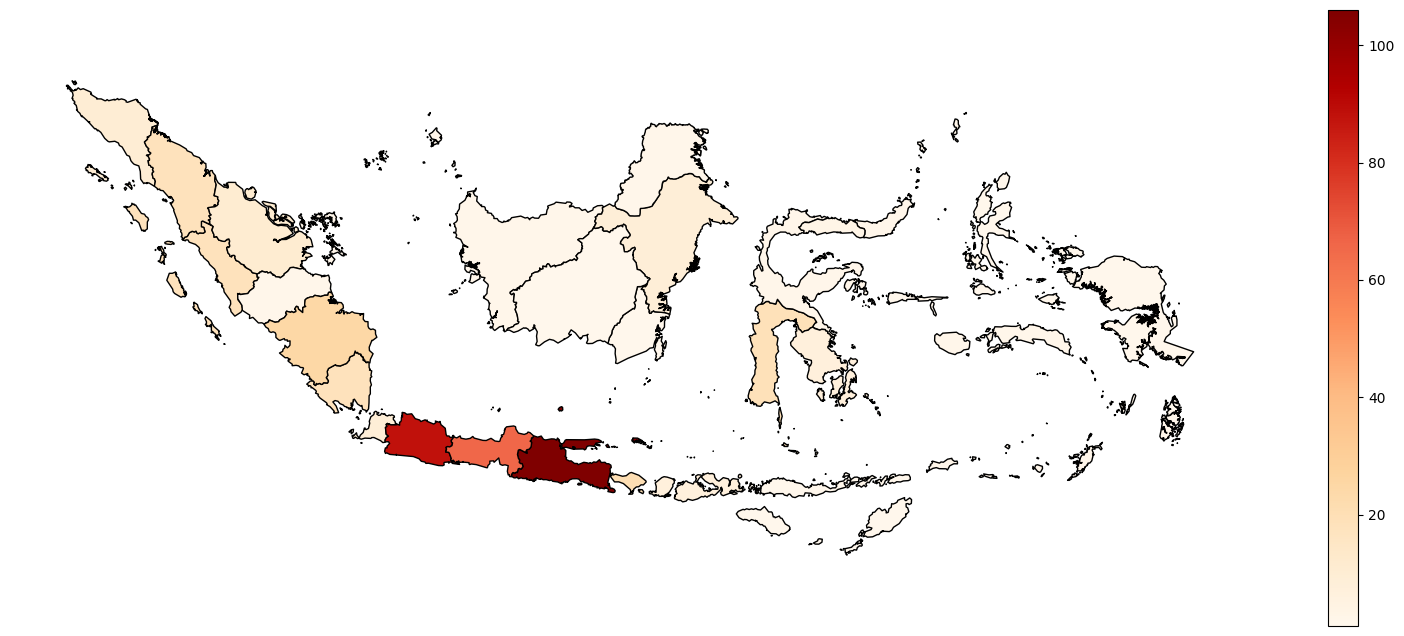

In [122]:


# Plot sederhana (tanpa basemap)
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
gdf.plot(column='count', ax=ax, cmap='OrRd', edgecolor='black', legend=True)
ax.axis('off')  # Hilangkan sumbu
plt.savefig("")
plt.savefig("Distribusi AI.png")
plt.show()


In [134]:
url = "https://raw.githubusercontent.com/ans-4175/peta-indonesia-geojson/master/indonesia-prov.geojson"
gdf = gpd.read_file(url)

0             Nusatenggara Barat
1                      Gorontalo
2              Sulawesi Tenggara
3     Daerah Istimewa Yogyakarta
4                    Jawa Tengah
5                         Banten
6                     Jawa Timur
7                   Maluku Utara
8                         Maluku
9               Sulawesi Selatan
10                   Dki Jakarta
11                    Jawa Barat
12                         Papua
13           Nusa Tenggara Timur
14                          Bali
15                          Riau
16                Kepulauan Riau
17                Sulawesi Barat
18               Sulawesi Tengah
19                Sulawesi Utara
20                   Papua Barat
21                Sumatera Utara
22               Bangka Belitung
23                Sumatera Barat
24              Sumatera Selatan
25                         Jambi
26                       Lampung
27                      Bengkulu
28                      Di. Aceh
29              Kalimantan Barat
30        

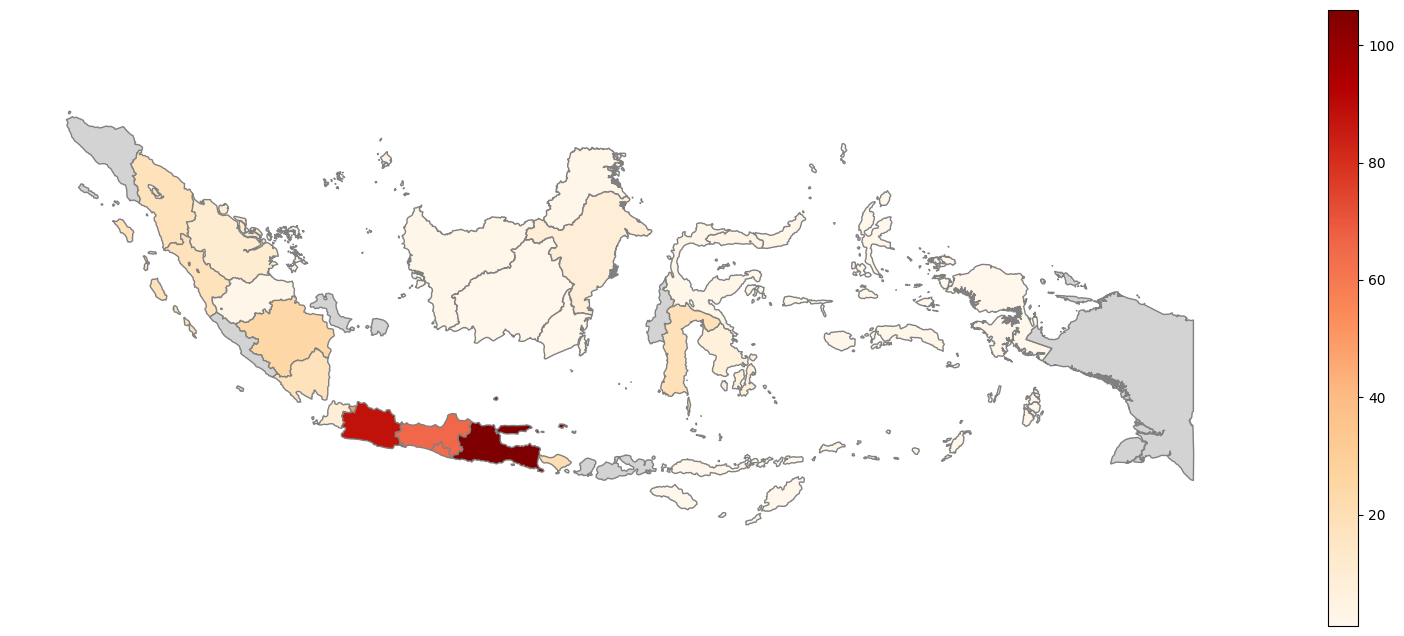

In [144]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# GeoJSON terbaru dengan pemetaan lengkap
url = "https://raw.githubusercontent.com/ans-4175/peta-indonesia-geojson/master/indonesia-prov.geojson"
gdf = gpd.read_file(url)
gdf['Propinsi'] = gdf['Propinsi'].str.title()
gdf = gdf.rename(columns={'Propinsi':'Provinsi'})

merged = gdf.merge(df_prov, on='Provinsi', how='left')

# Plot peta sederhana
fig, ax = plt.subplots(figsize=(20, 8))
merged.plot(column='count', ax=ax, cmap='OrRd', edgecolor='grey', legend=True,
            missing_kwds={"color": "lightgrey"})
ax.axis('off')
plt.savefig('Distribusi AI 2.png')
plt.show()